In [3]:
using CSV, DataFrames, Plots
dat = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2.csv",DataFrame)[:,vcat([2],4:(end-1))]
dat1 = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2.csv",DataFrame)[:,3]
dat2 = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2.csv",DataFrame)[:,end]
dat[:,2:end] .= log.(dat[:,2:end] .+ 1e-2)
dat[1:4,:]

Row,year,lat_36_00450,lat_36_00900,lat_36_01350,lat_36_01800,lat_36_02250,lat_36_02700,lat_36_03150,lat_36_03600,lat_36_04050,lat_36_04500,lat_36_05849,lat_36_06299,lat_36_06749,lat_36_07199,lat_36_07649,lat_36_08099,lat_36_08549,lat_36_08999,lat_36_09449,lat_36_09899,lat_36_10349,lat_36_10799,lat_36_11249,lat_36_11698,lat_36_12148,lat_36_12598,lat_36_13048,lat_36_13498,lat_36_13948,lat_36_14398,lat_36_14848,lat_36_15298,lat_36_15748,lat_36_16198,lat_36_16648,lat_36_17098,lat_36_17547,lat_36_17997,lat_36_18447,lat_36_19347,lat_36_19797,lat_36_20247,lat_36_20697,lat_36_21147,lat_36_21597
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1984,-2.43795,-1.9025,-3.84914,-2.52832,-2.81083,-4.36208,-3.05077,-2.64698,-2.078,-4.60517,-4.60517,-4.4405,-0.915513,-1.75641,-1.20027,-1.94119,-1.03678,-3.6812,-4.60517,-2.11977,-0.804252,-1.58474,-1.26537,-4.60517,-1.63233,-1.64554,-3.99349,-1.54454,-1.5023,-2.58547,-1.63941,-1.50151,-3.37547,-1.77406,-1.05368,-1.8842,-1.73123,-2.8656,-3.78178,-4.60517,-3.34028,-0.681664,-0.955537,-1.71432,-1.09559
2,1985,-0.800995,-0.0137745,-0.83556,-0.240423,-0.495683,-1.25267,-0.535848,-0.327685,-0.13533,-1.00457,-4.60517,-1.18451,-0.0618075,-0.0644594,-0.204018,-0.0798734,0.00995033,-0.143568,-2.46943,-0.270178,0.00995033,0.00995033,0.00995033,-0.360923,0.00995033,0.00995033,-0.972054,0.00995033,-0.0189833,0.00995033,0.00995033,-0.100928,-0.803451,-0.223033,-0.459067,-0.522358,-0.316985,-0.445064,-1.22421,-3.97851,0.00995033,0.00995033,0.00995033,0.00995033,0.00995033
3,1986,-1.80098,-0.83091,-1.09486,-0.365123,-1.0107,-1.4645,-0.744626,-1.55959,-1.72477,-3.80866,-4.60517,-3.27246,-1.5777,-1.87296,-1.83918,-1.09126,-1.98384,-1.46933,-4.07004,-1.38429,-1.06248,-0.923027,-0.944995,-4.2058,-1.92127,-1.7083,-2.88632,-1.65098,-1.98705,-1.68482,-0.840014,-1.78871,-3.57587,-2.22096,-1.06171,-2.03188,-1.18065,-1.0208,-0.732183,-1.65437,-1.36028,-1.4828,-2.29586,-1.45745,-2.77032
4,1987,-0.817995,-0.640768,-1.0418,-0.291619,-0.977762,-1.07758,-0.639388,-1.05079,-1.25423,-2.63243,-4.60517,-2.13682,-0.625342,-0.879395,-0.796447,-0.757462,-0.825752,-2.17458,-3.33211,-1.30186,-0.760597,-0.94546,-1.07241,-1.57449,-1.05118,-1.04158,-2.51289,-1.23411,-1.34993,-1.25475,-0.864295,-0.919857,-4.20464,-1.1366,-0.550202,-0.548903,-0.84814,-0.67096,-0.173496,-0.579667,-0.618157,-0.589606,-0.49708,-0.816267,-1.35927


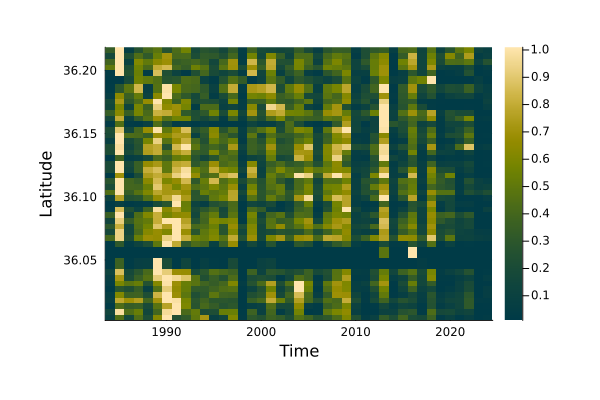

In [4]:
function get_latitude(nm)
m = match(r"(?<integer>\d+)_(?<decimal>\d+)",nm)
parse(Float64,(m[:integer])) + parse(Float64,(string("0.",m[:decimal])))
end 

lats = get_latitude.(names(dat[:,2:end]))
using Plots.PlotMeasures
Plots.heatmap(dat.year,lats,exp.(Matrix(dat[:,2:end]))', c= :bamako, size = (600,400),
ylabel = "Latitude", xlabel = "Time", margin = 10mm)

In [5]:
dat_K = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2_K.csv",DataFrame)[:,4:(end-1)]
K1 = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2_K.csv",DataFrame)[:,3]
K2 = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2_K.csv",DataFrame)[:,end]

# dat_K = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2_K.csv",DataFrame)[:,20:30]
# K1 = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2_K.csv",DataFrame)[:,19]
# K2 = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2_K.csv",DataFrame)[:,31]

K = Matrix(dat_K)[1,:]
K

45-element Vector{Float64}:
 0.174105861214001
 0.687939289908754
 1.0
 0.358026922034511
 0.361700846207125
 0.270952911534717
 0.337509159715321
 0.120534826994308
 0.114090402625952
 0.00942170827435982
 ⋮
 0.0294435912106885
 0.0336093795484888
 0.0274118910671445
 0.0231196233725821
 0.0111663203541422
 0.296644281828129
 0.142190903524357
 0.11825016813724
 0.105016010680479

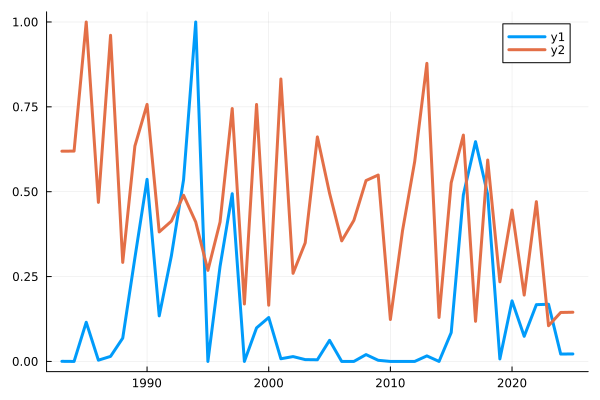

In [6]:
using Statistics
mu_t1 = dat1
mu_t1 = vcat([mean(mu_t1)],mu_t1,[mean(mu_t1)])
years = vcat([1500],dat.year, [2500])

mu_t2 = dat2
mu_t2 = vcat([mean(mu_t2)],mu_t2,[mean(mu_t2)])
years = vcat([1500],dat.year, [2500])

function mu(t,mu_t)
    ind_lower = maximum(eachindex(years)[years .<= t])
    ind_upper = minimum(eachindex(years)[years .> t])
    t_lower = years[ind_lower]
    t_upper = years[ind_upper]
    mu_lower = mu_t[ind_lower]
    mu_upper = mu_t[ind_upper]

    mu = mu_lower + (t-t_lower)/(t_upper-t_lower)*(mu_upper-mu_lower)
    return mu
end 
tvals = 1983:0.25:2025
Plots.plot(tvals, broadcast(t ->mu(t,mu_t1), tvals), linewidth = 3)
Plots.plot!(tvals, broadcast(t ->mu(t,mu_t2), tvals), linewidth = 3)

In [7]:
X = CSV.read("../processed_data/sst_500m_bins.csv",DataFrame)[:,2:end]
X = X[broadcast(v -> v in names(dat),X.variable),: ]
unique(X.variable)

45-element Vector{String15}:
 "lat_36_00450"
 "lat_36_00900"
 "lat_36_01350"
 "lat_36_01800"
 "lat_36_02250"
 "lat_36_02700"
 "lat_36_03150"
 "lat_36_03600"
 "lat_36_04050"
 "lat_36_04500"
 ⋮
 "lat_36_17547"
 "lat_36_17997"
 "lat_36_18447"
 "lat_36_19347"
 "lat_36_19797"
 "lat_36_20247"
 "lat_36_20697"
 "lat_36_21147"
 "lat_36_21597"

In [8]:
include("../src/UDE.jl")
model, NN = init_model(dat,X,K,t -> mu(t,mu_t1),t -> mu(t,mu_t2),K1,K2,1;hidden = 10,seed = 456)
nothing

In [9]:
function training!(model,reg_weight)
α = UniversalDiffEq.train!(model, loss_function = "spline gradient matching", regularization_weight = reg_weight, 
        optim_options = (maxiter = 500, step_size = 0.025), loss_options = (σ = 0.05, τ = 0.025, T = 160))
end
training!(model,1e3)
nothing

162
3.187173524e6 1.9532054882e7 3.658823462e6 4.771220937e6 5.93002124e6 6.35690265e6 6.18780644e6 5.228728793e6 4.914266907e6 4.78030355e6 4.625632666e6 4.399240891e6 4.114447374e6 3.839578836e6 3.607720322e6 3.400143951e6 3.195989748e6 3.000064198e6 2.822022513e6 2.664606369e6 2.52908582e6 2.411044562e6 2.297728978e6 2.184465449e6 2.075728296e6 1.970630508e6 1.87618482e6 1.794772681e6 1.724870798e6 1.667043317e6 1.620687165e6 1.584044973e6 1.552969196e6 1.523183426e6 1.493456971e6 1.463566087e6 1.431859098e6 1.399648435e6 1.367923928e6 1.337659589e6 1.310016675e6 1.285894685e6 1.265679919e6 1.249037623e6 1.235379848e6 1.222181325e6 1.207659677e6 1.191418356e6 1.174302145e6 1.157996704e6 1.143201039e6 1.129867287e6 1.118313422e6 1.107773396e6 1.097447036e6 1.086997148e6 1.076518451e6 1.066316796e6 1.056605332e6 1.04743206e6 1.038823817e6 1.030760491e6 1.023294449e6 1.016181089e6 1.009225081e6 1.002427193e6 995856.667 989567.339 983576.201 977895.579 972592.122 967602.361 963000.53 95

In [10]:
using JLD2
save_object("../results/parameters/model2_0.025_1e3.jld",model.parameters)

In [11]:
rhs = UniversalDiffEq.get_right_hand_side(model)
f_rhs = (u,X,site) -> rhs(zeros(length(K)) .+ u  , repeat([X],65), 2000.0)[site]
f_rhs(0.0,0.0,2)

-0.08058336202681754

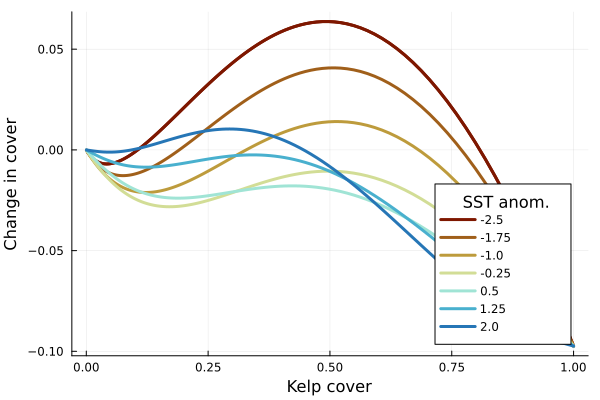

In [19]:
Xvals = -2.5:0.75:2.5; site = 5
uvals = -8.0:0.025:0.0
colors = cgrad(:roma)[1:round(Int,256/length(Xvals)-1):256]
p1 = Plots.plot(exp.(uvals),exp.(uvals).*f_rhs.(uvals,Xvals[1],site), color = colors[1], label = "",width=3)
i = 0
for X in Xvals
    i += 1
    Plots.plot!(p1,exp.(uvals),exp.(uvals).*f_rhs.(uvals,X,site), color = colors[i], label = string("",round(X,digits = 3)),width=3)
end
Plots.plot!(p1, xlabel = "Kelp cover", ylabel = "Change in cover", legendtitle = "SST anom.",legendposition = :bottomright)

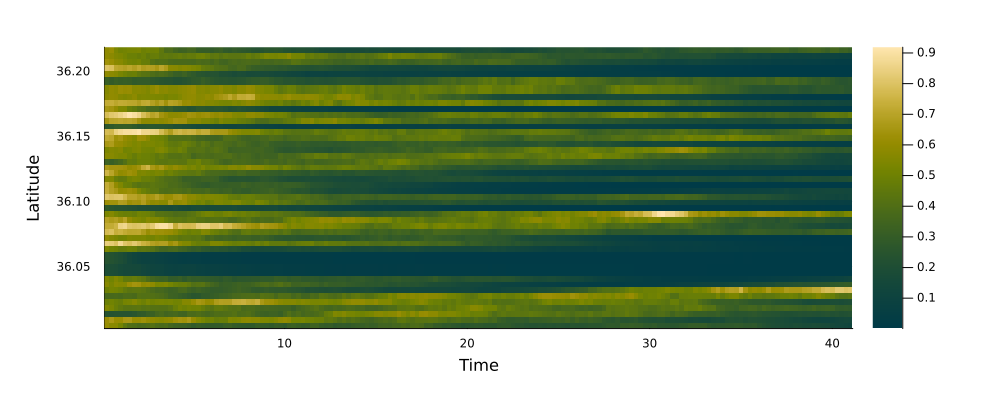

In [27]:
u = model.parameters.uhat[:,1]
X = [0.0,0.0] .+ -2.0
T = 2025-1984
dt = 0.25
uvals = zeros(length(K), round(Int,T/dt))
i = 0
for t in (1984+dt):dt:2025
    i+=1
    u[u.>0] .= 0
    uvals[:,i] = u
    X = model.process_model.covariates(t)
    u = u + dt*rhs(u,X,t).+sqrt(dt)*0.1*randn(length(K))
end

function get_latitude(nm)
m = match(r"(?<integer>\d+)_(?<decimal>\d+)",nm)
parse(Float64,(m[:integer])) + parse(Float64,(string("0.",m[:decimal])))
end 

lats = get_latitude.(names(dat[:,2:end]))

using Plots.PlotMeasures
Plots.heatmap(dt:dt:T,lats,exp.(uvals), c= :bamako, size = (1000,400),
ylabel = "Latitude", xlabel = "Time", margin = 10mm)

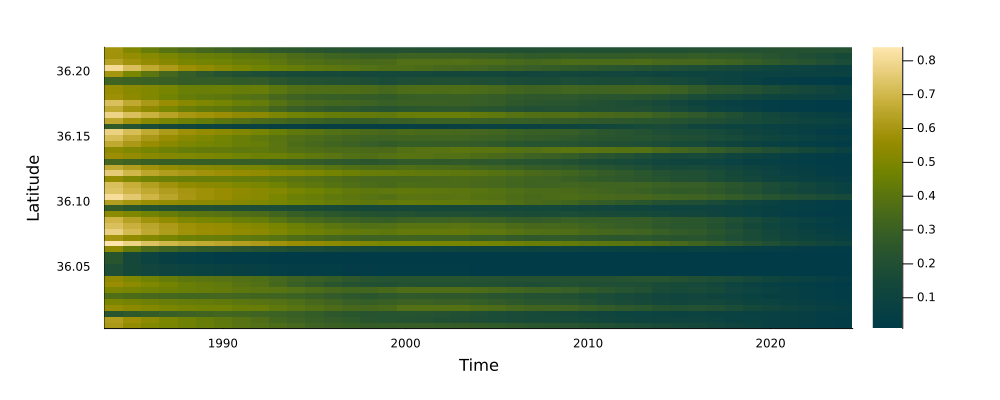

In [22]:
Plots.heatmap(dat.year,lats,exp.(Matrix(model.parameters.uhat)), c= :bamako, size = (1000,400),
ylabel = "Latitude", xlabel = "Time", margin = 10mm)

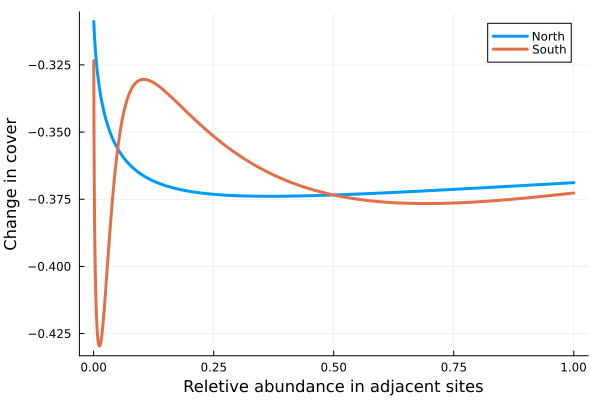

In [15]:
rhs = UniversalDiffEq.get_right_hand_side(model)
function f_rhs1_(u,X,site)
    u0 = K.+log(0.5)
    u0[site + 1] = u .+ K[site+1]
    rhs(u0, repeat([X],length(K)), 2000.0)[site]
end
function f_rhs2_(u,X,site)
    u0 = K.+log(0.5)
    u0[site - 1] = u .+ K[site-1]
    rhs(u0, repeat([X],length(K)), 2000.0)[site]
end

Xvals = -2.5:0.75:2.5; site = 10
uvals = -8.0:0.025:0.0
colors = cgrad(:roma)[1:round(Int,256/length(Xvals)-1):256]
p1 = Plots.plot(exp.(uvals),exp(0.5*K[site]).*f_rhs1_.(uvals,0.0,site), label = "North",width=3)
Plots.plot!(exp.(uvals),exp(0.5*K[site]).*f_rhs2_.(uvals,0.0,site),  label = "South",width=3, xlabel = "Reletive abundance in adjacent sites",
ylabel = "Change in cover")

In [16]:
length(model.parameters)

1961

In [17]:
optim_opts = (samples = 4000, burnin = 2000, Σ0 = 2*1e-3)
params,nll,interp = UniversalDiffEq.train!(model; 
                        loss_function = "spline gradient matching", optimizer = "MCMC",
                        regularization_weight = 1e1, loss_options = (σ = 0.1, τ = 0.05, T = 60, α = α),
                        optim_options = optim_opts, verbose = false)
Plots.plot(nll)

UndefVarError: UndefVarError: `α` not defined

In [18]:
function get_samples(Nsteps)
    seeds = [123,234,345,456,567,678]; Nchains = length(seeds)
    model, NN = init_model(dat,X,K,t -> mu(t,mu_t1),t -> mu(t,mu_t2),K1,K2,1;hidden = 10,seed = seeds[1])
    training!(model,1e2)
    parameters = Vector{typeof(params)}(undef, Nsteps*Nchains)
    for i in 1:Nchains
        optim_opts = (samples = 20000, burnin = 5000, Σ0 = 2*1e-3)

params,nll,interp = UniversalDiffEq.train!(model_sgld; 
                        loss_function = "spline gradient matching", optimizer = "MCMC",
                        regularization_weight = 1e1, loss_options = (σ = 0.1, τ = 0.05, T = 60, α = α),
                        optim_options = optim_opts, verbose = false)
    end
end 

get_samples (generic function with 1 method)